Country: India
Optimal β: 0.1859, Optimal γ: 0.1011
last 10 actual Cases: [ 767296  793802  820916  849522  878254  906752  936181  968857 1003832
 1039084]

last 10 Predicted Cases: [ 854050.96836253  891104.36924401  927574.49360198  963208.7770156
  997751.01932386 1030945.51194463 1062541.35994395 1092296.87135338
 1119983.85508446 1145391.7219366 ]

Country: US
Optimal β: 0.1415, Optimal γ: 0.0386
last 10 actual Cases: [3054699 3117946 3185737 3245925 3304942 3364157 3431574 3498902 3576157
 3647715]

last 10 Predicted Cases: [3730533.91589959 3722532.58049123 3707618.40809472 3686253.06558434
 3658913.02858577 3626081.33160305 3588240.4142108  3545866.06513164
 3499422.43902222 3449358.00725503]

Country: Brazil
Optimal β: 0.1609, Optimal γ: 0.0676
last 10 actual Cases: [1713160 1755779 1800827 1839850 1864681 1884967 1926824 1966748 2012151
 2046328]

last 10 Predicted Cases: [1992212.92526562 2031041.5224503  2064849.8302881  2093459.40521217
 2116753.50654148 2134676.56557723 

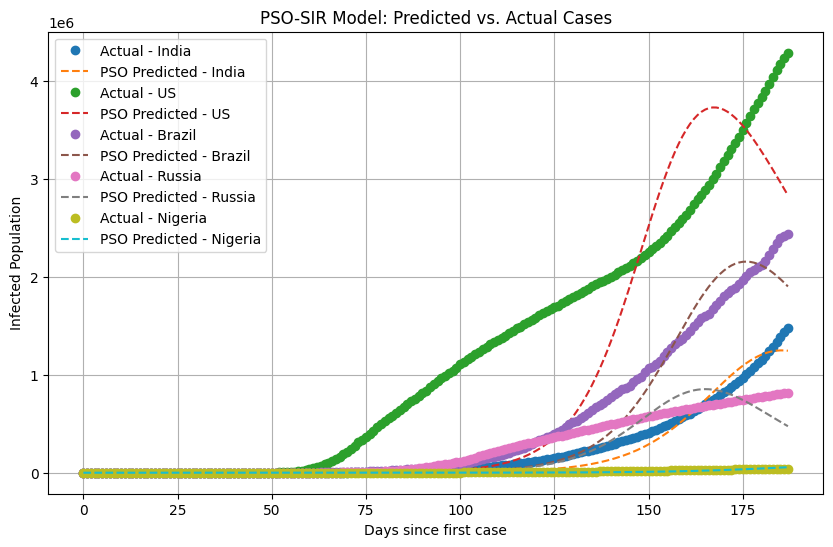

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Load COVID-19 dataset
df = pd.read_csv("covid_19_clean_complete.csv")  # Replace with actual dataset file

# Select multiple countries for comparison
countries = ["India", "US", "Brazil", "Russia", "Nigeria"]  # Add more as needed

# SIR Model equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    N = S + I + R
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Particle class representing (β, γ)
class Particle:
    def __init__(self, actual_cases, y0, t):
        self.actual_cases = actual_cases
        self.y0 = y0
        self.t = t
        self.position = np.random.uniform(0.0001, 0.5, 2)  # (β, γ) initialization
        self.velocity = np.random.uniform(-0.01, 0.01, 2)
        self.pbest = self.position.copy()
        self.fitness = self.calculate_fitness(self.position)
        self.pbest_fitness = self.fitness

    def calculate_fitness(self, position):
        beta, gamma = position
        solution = odeint(sir_model, self.y0, self.t, args=(beta, gamma))
        predicted_cases = solution[:, 1]  # Extract I (infected)

        if len(predicted_cases) != len(self.actual_cases):
            return 0  # Avoid invalid fitness

        mse = np.mean((predicted_cases - self.actual_cases) ** 2)
        return 1 / (1 + mse)  # Use inverse MSE (higher is better)

# PSO class
class PSO:
    def __init__(self, actual_cases, y0, t, num_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5):
        self.actual_cases = actual_cases
        self.y0 = y0
        self.t = t
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = [Particle(actual_cases, y0, t) for _ in range(num_particles)]
        self.gbest = max(self.particles, key=lambda p: p.fitness).position

    def optimize(self):
        for _ in range(self.max_iter):
            for particle in self.particles:
                r1, r2 = np.random.rand(), np.random.rand()
                cognitive = self.c1 * r1 * (particle.pbest - particle.position)
                social = self.c2 * r2 * (self.gbest - particle.position)
                particle.velocity = self.w * particle.velocity + cognitive + social

                # Update position (β and γ must be in range)
                particle.position += particle.velocity
                particle.position = np.clip(particle.position, 0.0001, 0.5)


                # Evaluate fitness
                new_fitness = particle.calculate_fitness(particle.position)
                if new_fitness > particle.pbest_fitness:
                    particle.pbest = particle.position.copy()
                    particle.pbest_fitness = new_fitness

            # Update global best
            self.gbest = max(self.particles, key=lambda p: p.pbest_fitness).pbest

        return self.gbest

# Initialize plot
plt.figure(figsize=(10, 6))

# Process each country
for country in countries:
    country_df = df[df["Country/Region"] == country].groupby("Date")[["Confirmed"]].sum().reset_index()
    
    # Convert dates to numerical values (days since first case)
    country_df["Date"] = pd.to_datetime(country_df["Date"])
    country_df["Day"] = (country_df["Date"] - country_df["Date"].min()).dt.days

    # Extract data for PSO
    actual_cases = country_df["Confirmed"].values
    t = np.arange(len(actual_cases))  # Use sequential days

    # SIR model initial conditions
    N = 10000000  # Approximate population, change for each country if needed
    I0 = actual_cases[0] if actual_cases[0] > 0 else 1  # Avoid zero division
    S0 = N - I0
    R0 = 0
    y0 = [S0, I0, R0]

    # Run PSO to optimize (β, γ)
    pso = PSO(actual_cases, y0, t)
    beta_opt, gamma_opt = pso.optimize()

    # Solve SIR with optimized parameters
    solution = odeint(sir_model, y0, t, args=(beta_opt, gamma_opt))
    predicted_cases = solution[:, 1]

    # Print results
    print(f"Country: {country}")
    print(f"Optimal β: {beta_opt:.4f}, Optimal γ: {gamma_opt:.4f}")
    print(f"last 10 actual Cases: {actual_cases[-20:-10]}\n")
    print(f"last 10 Predicted Cases: {predicted_cases[-20:-10]}\n")

    # Plot actual vs. predicted cases
    plt.plot(t, actual_cases, "o", label=f"Actual - {country}")
    plt.plot(t, predicted_cases, "--", label=f"PSO Predicted - {country}")

# Show visualization
plt.xlabel("Days since first case")
plt.ylabel("Infected Population")
plt.title("PSO-SIR Model: Predicted vs. Actual Cases")
plt.legend()
plt.grid()
plt.show()

Country: India
Optimal β: 0.1859, Optimal γ: 0.1011
Last 10 actual Cases: [ 767296  793802  820916  849522  878254  906752  936181  968857 1003832
 1039084]
Last 10 Predicted Cases (PSO): [ 854051.45492536  891104.8491918   927574.96315105  963209.23225149
  997751.45626056 1030945.92658815 1062541.74836007 1092297.2297364
 1119984.17982582 1145392.00968956]
Last 10 Predicted Cases (Traditional): [6773.76715391 6239.84855124 5747.99495436 5294.89517583 4877.49822771
 4492.99294281 4138.78918032 3812.50049535 3511.92816375 3235.04644629]



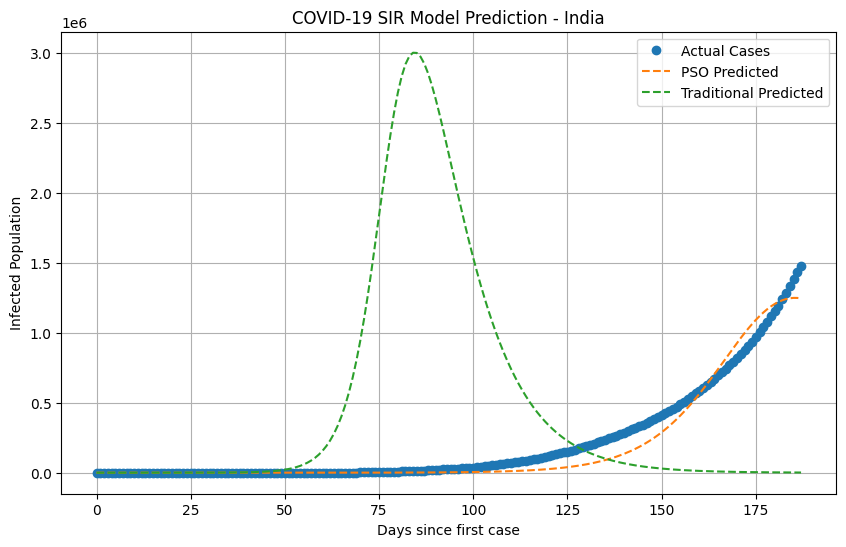

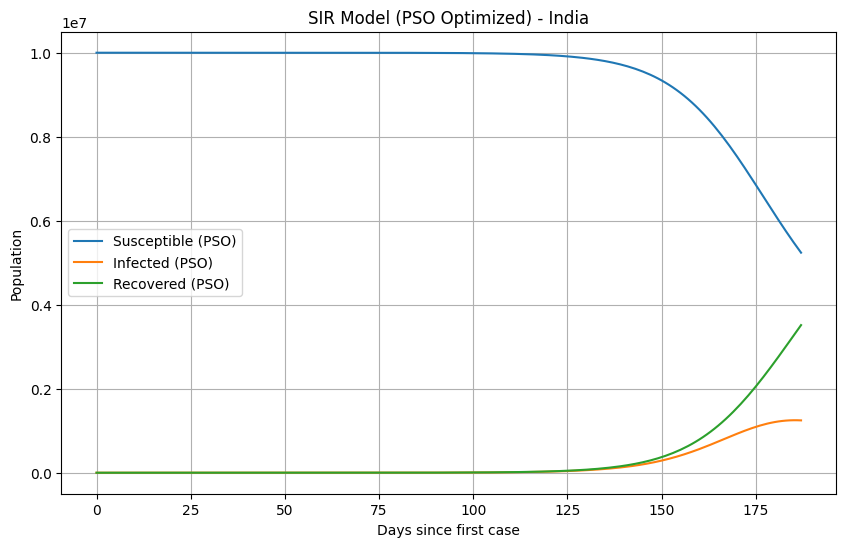

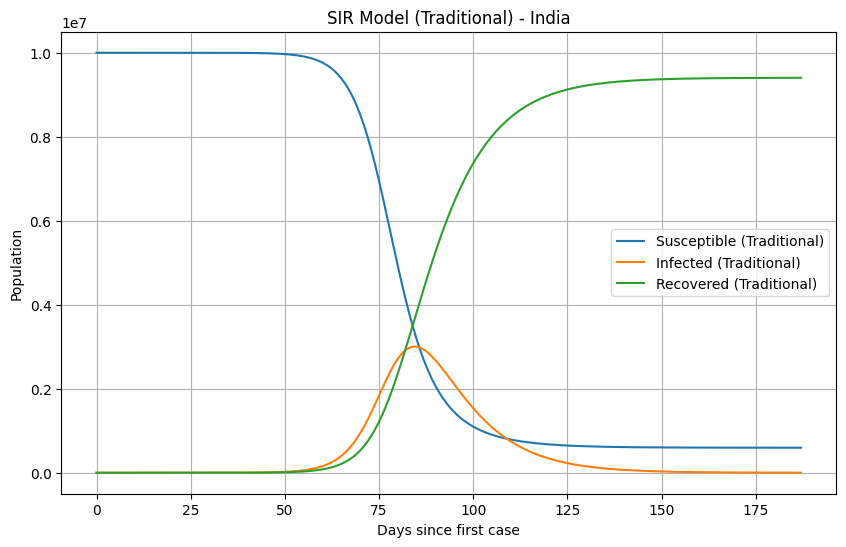

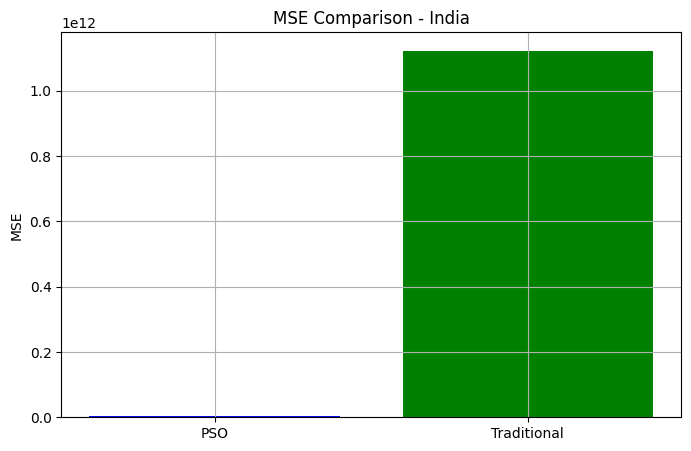

Country: US
Optimal β: 0.1415, Optimal γ: 0.0386
Last 10 actual Cases: [3054699 3117946 3185737 3245925 3304942 3364157 3431574 3498902 3576157
 3647715]
Last 10 Predicted Cases (PSO): [3730534.92409475 3722533.83376513 3707619.89329865 3686254.76869554
 3658914.93498579 3626083.42632925 3588242.68217618 3545868.49131518
 3499425.00862948 3449360.7058485 ]
Last 10 Predicted Cases (Traditional): [6773.76715391 6239.84855124 5747.99495436 5294.89517583 4877.49822771
 4492.99294281 4138.78918032 3812.50049535 3511.92816375 3235.04644629]



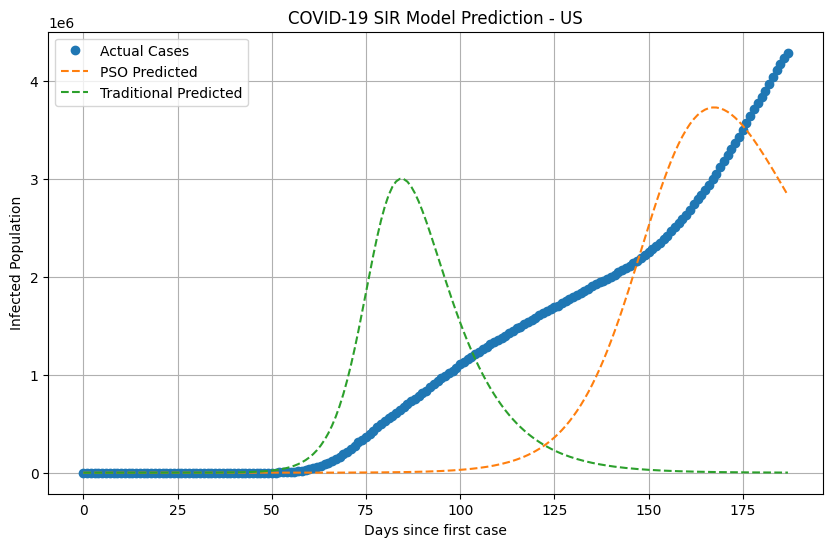

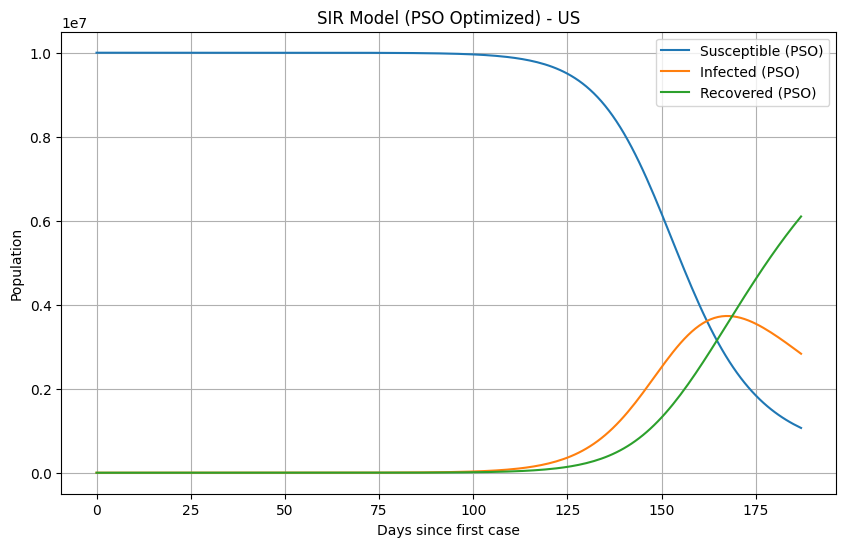

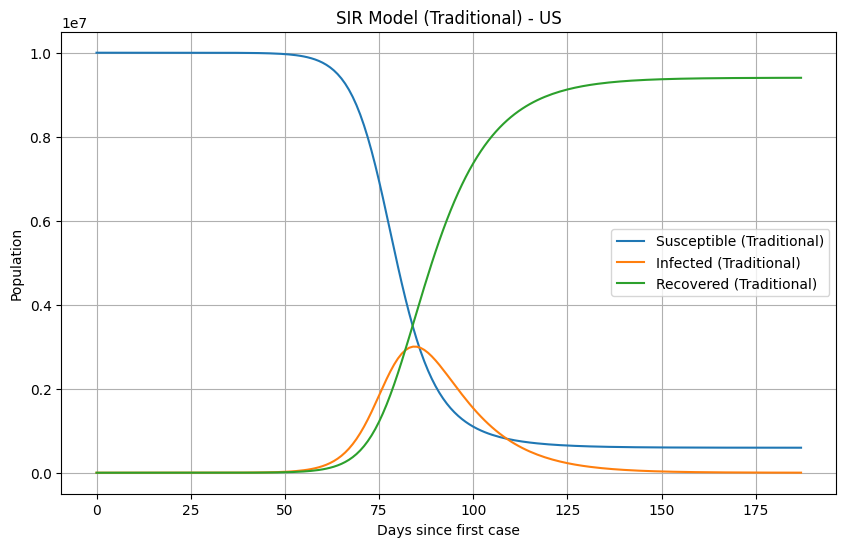

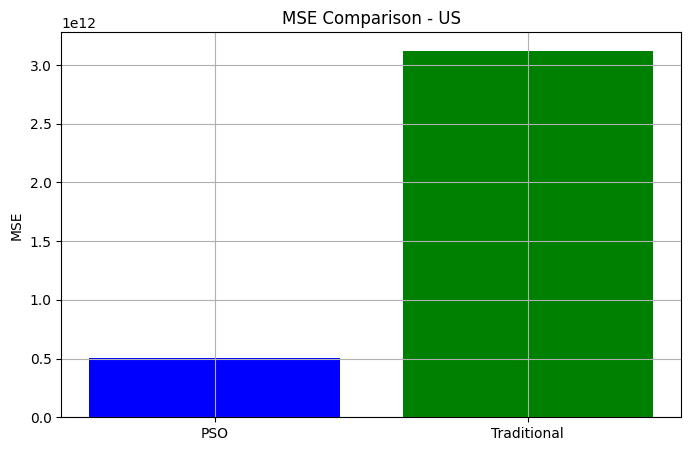

Country: Brazil
Optimal β: 0.1609, Optimal γ: 0.0676
Last 10 actual Cases: [1713160 1755779 1800827 1839850 1864681 1884967 1926824 1966748 2012151
 2046328]
Last 10 Predicted Cases (PSO): [1992213.43527423 2031041.97440042 2064850.22084175 2093459.73175793
 2116753.7672162  2134676.7592687  2147232.38484018 2154480.28900612
 2156531.78468648 2153544.65737306]
Last 10 Predicted Cases (Traditional): [6773.76715391 6239.84855124 5747.99495436 5294.89517583 4877.49822771
 4492.99294281 4138.78918032 3812.50049535 3511.92816375 3235.04644629]



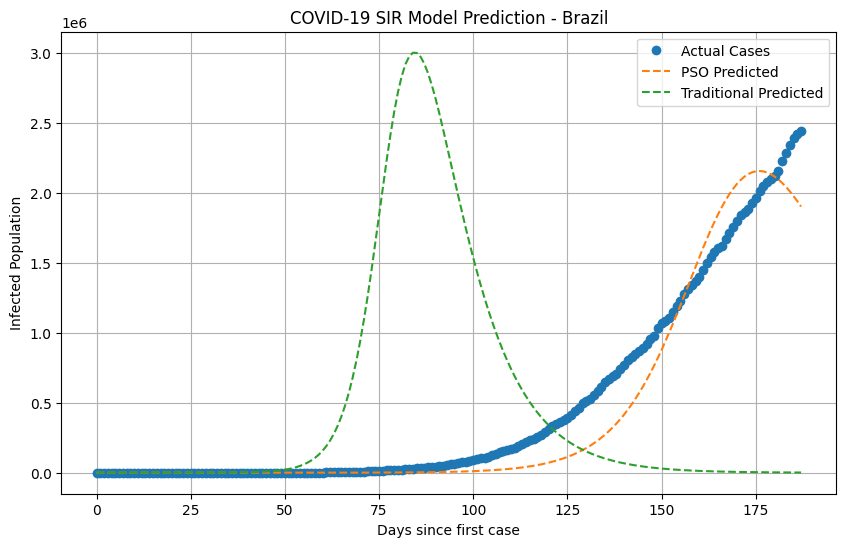

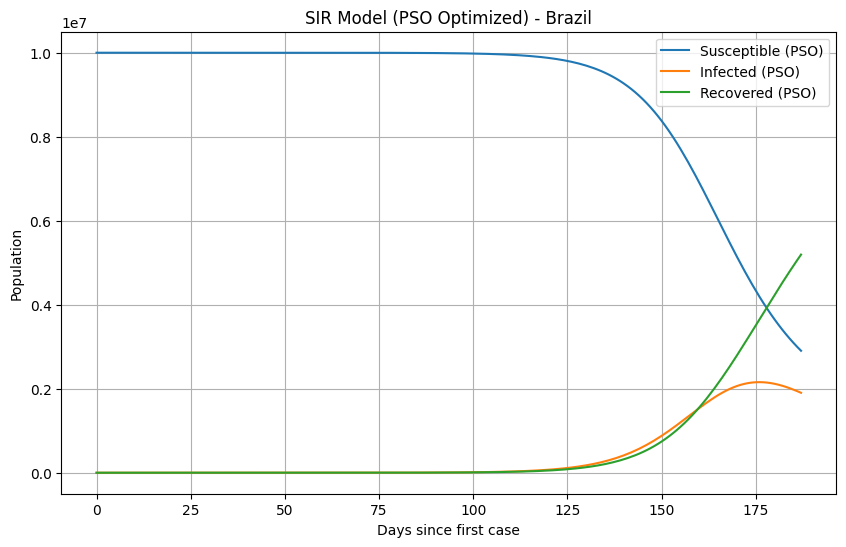

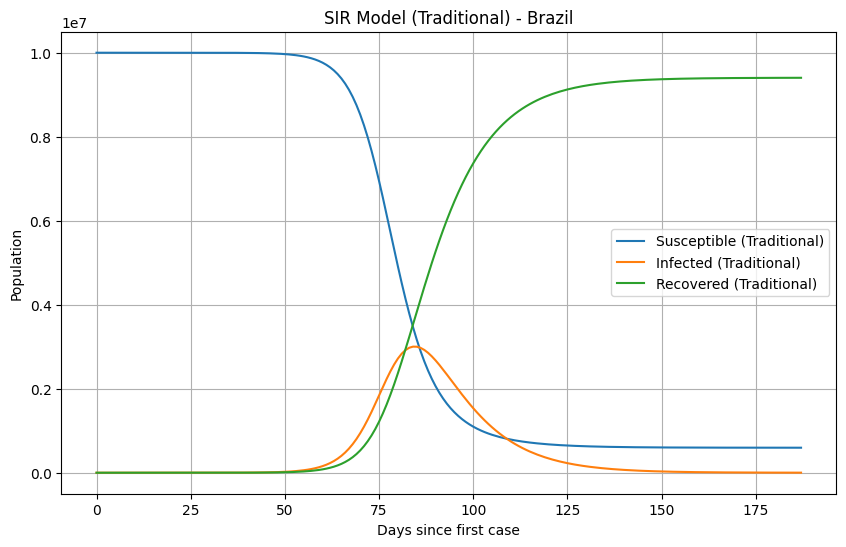

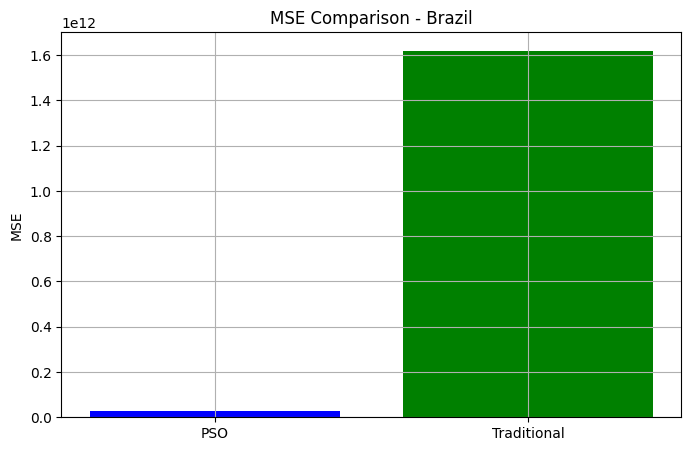

Country: Russia
Optimal β: 0.2413, Optimal γ: 0.1487
Last 10 actual Cases: [699749 706240 712863 719449 726036 732547 738787 745197 751612 758001]
Last 10 Predicted Cases (PSO): [842901.36881258 834446.85138906 823797.59132583 811112.38127834
 796563.51762568 780332.86755765 762608.09685918 743579.16762127
 723435.16469536 702361.50134926]
Last 10 Predicted Cases (Traditional): [6773.76715391 6239.84855124 5747.99495436 5294.89517583 4877.49822771
 4492.99294281 4138.78918032 3812.50049535 3511.92816375 3235.04644629]



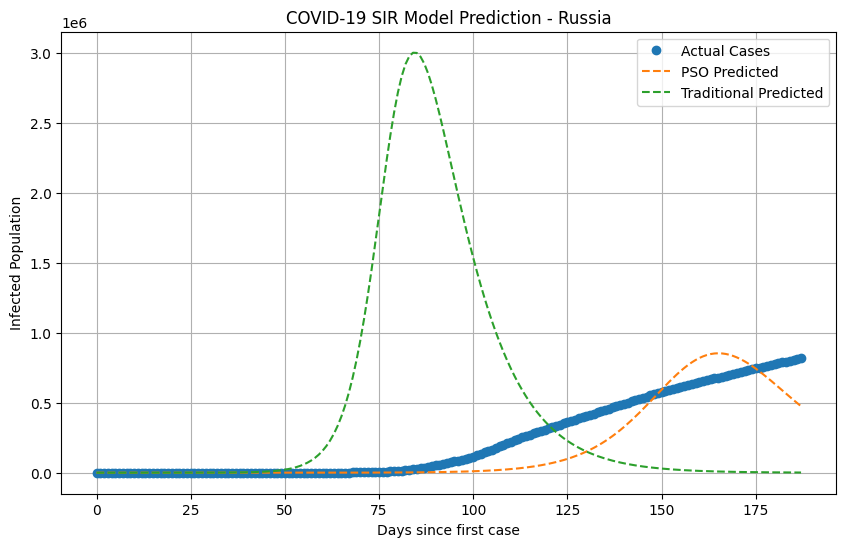

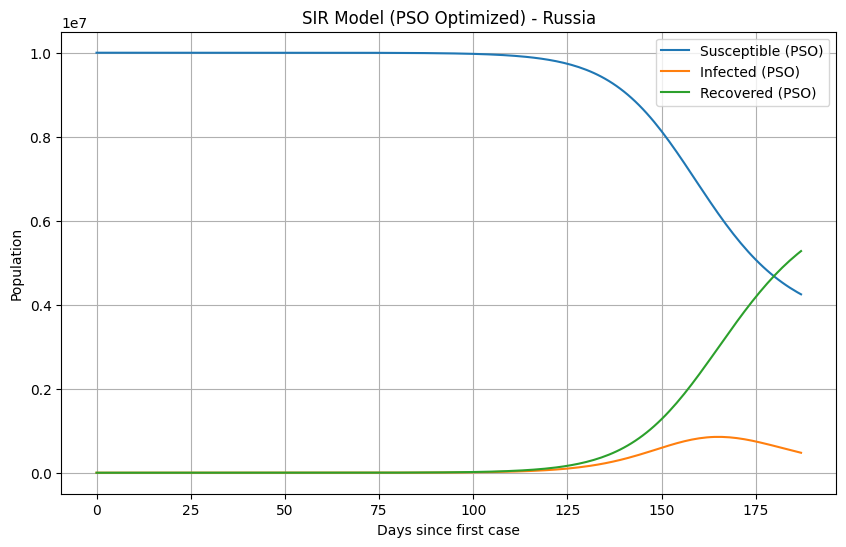

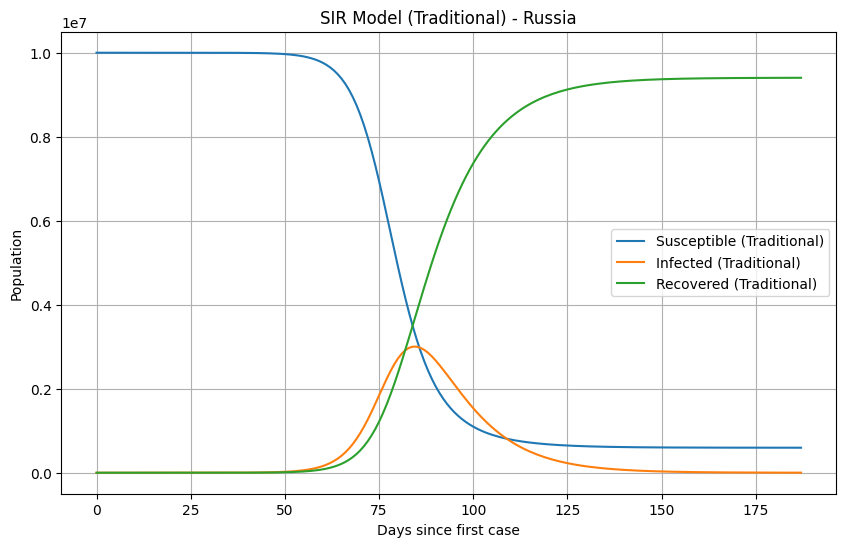

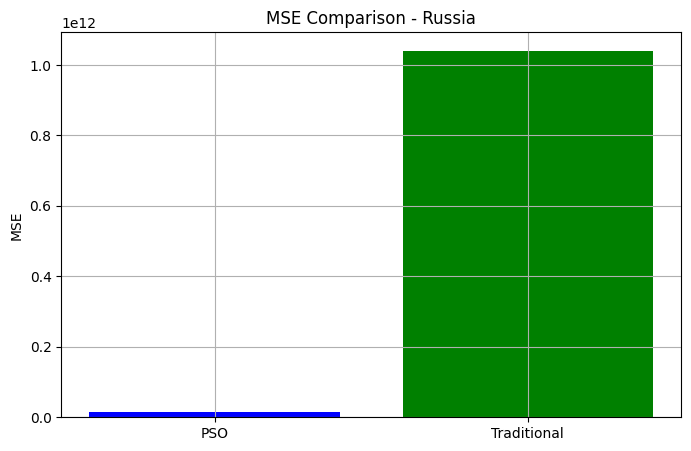

Country: Nigeria
Optimal β: 0.5000, Optimal γ: 0.4386
Last 10 actual Cases: [30249 30748 31323 31987 32558 33153 33616 34259 34854 35454]
Last 10 Predicted Cases (PSO): [25044.6991063  26329.42355238 27662.26091477 29042.97153571
 30471.04133712 31945.65470213 33465.66807781 35029.58313793
 36635.52132783 38281.19969082]
Last 10 Predicted Cases (Traditional): [6773.76715391 6239.84855124 5747.99495436 5294.89517583 4877.49822771
 4492.99294281 4138.78918032 3812.50049535 3511.92816375 3235.04644629]



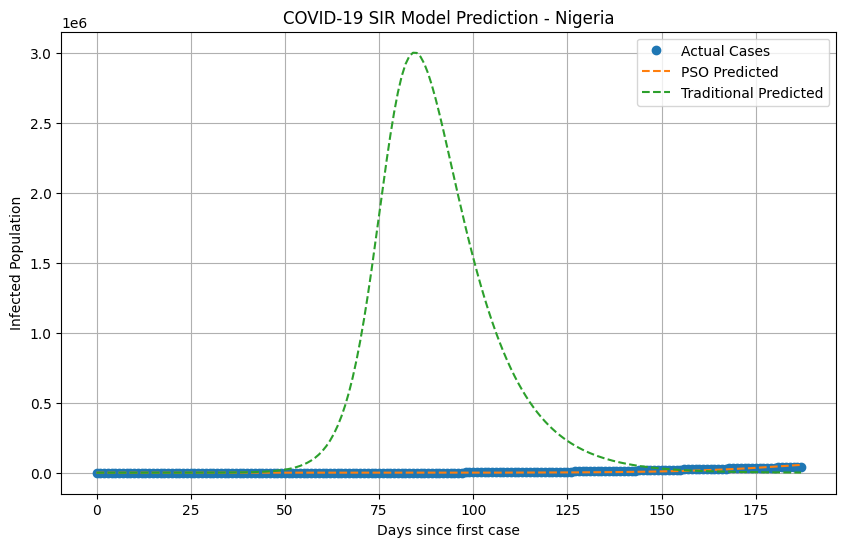

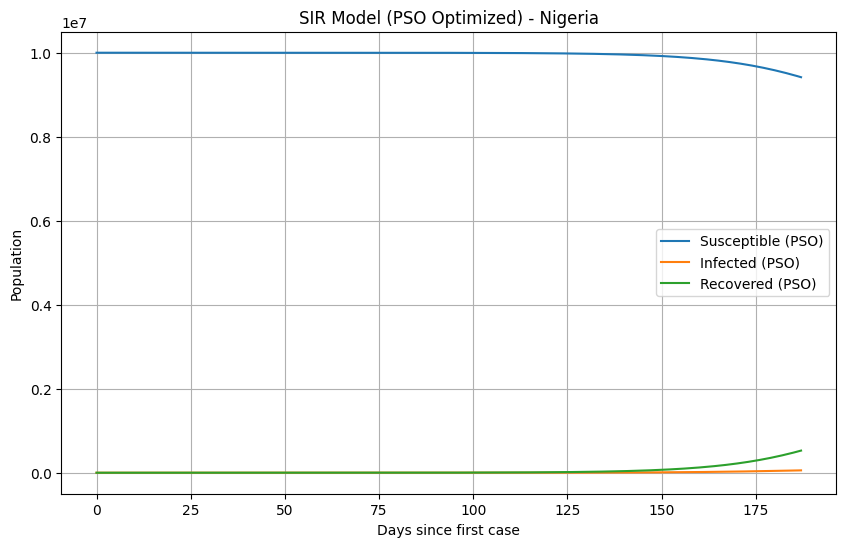

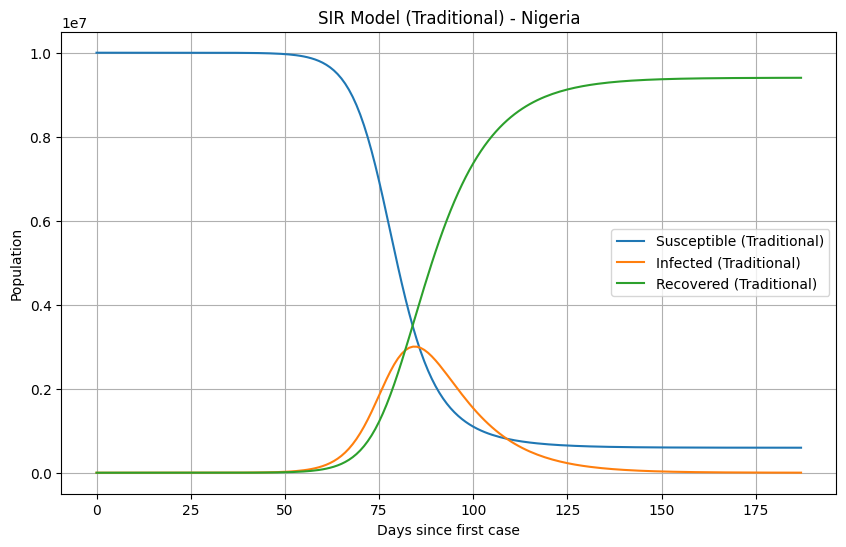

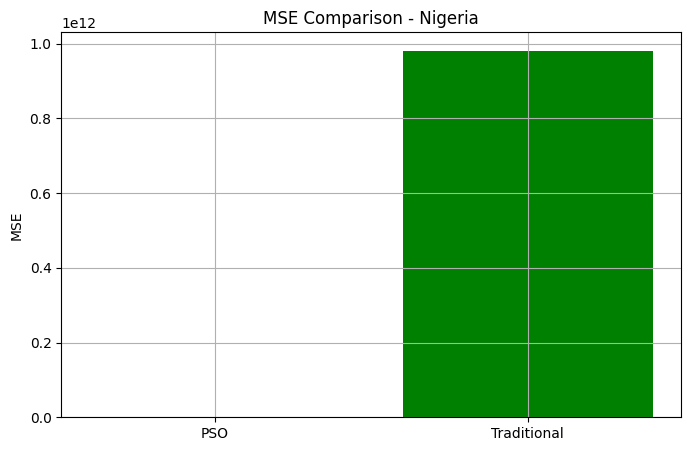

In [11]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.integrate import odeint

# # Load COVID-19 dataset
# df = pd.read_csv("covid_19_clean_complete.csv")  # Replace with actual dataset file

# # Select multiple countries for comparison
countries = ["India", "US", "Brazil", "Russia", "Nigeria"]

# # SIR Model equations
# def sir_model(y, t, beta, gamma):
#     S, I, R = y
#     N = S + I + R
#     dSdt = -beta * S * I / N
#     dIdt = beta * S * I / N - gamma * I
#     dRdt = gamma * I
#     return [dSdt, dIdt, dRdt]

# # Particle class representing (β, γ)
# class Particle:
#     def __init__(self, actual_cases, y0, t):
#         self.actual_cases = actual_cases
#         self.y0 = y0
#         self.t = t
#         self.position = np.random.uniform(0.0001, 0.5, 2)  # (β, γ) initialization
#         self.velocity = np.random.uniform(-0.01, 0.01, 2)
#         self.pbest = self.position.copy()
#         self.fitness = self.calculate_fitness(self.position)
#         self.pbest_fitness = self.fitness

#     def calculate_fitness(self, position):
#         beta, gamma = position
#         solution = odeint(sir_model, self.y0, self.t, args=(beta, gamma))
#         predicted_cases = solution[:, 1]  # Extract I (infected)

#         if len(predicted_cases) != len(self.actual_cases):
#             return 0  # Avoid invalid fitness

#         mse = np.mean((predicted_cases - self.actual_cases) ** 2)
#         return 1 / (1 + mse)  # Use inverse MSE (higher is better)

# # PSO class
# class PSO:
#     def __init__(self, actual_cases, y0, t, num_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5):
#         self.actual_cases = actual_cases
#         self.y0 = y0
#         self.t = t
#         self.num_particles = num_particles
#         self.max_iter = max_iter
#         self.w = w
#         self.c1 = c1
#         self.c2 = c2
#         self.particles = [Particle(actual_cases, y0, t) for _ in range(num_particles)]
#         self.gbest = max(self.particles, key=lambda p: p.fitness).position

#     def optimize(self):
#         for _ in range(self.max_iter):
#             for particle in self.particles:
#                 r1, r2 = np.random.rand(), np.random.rand()
#                 cognitive = self.c1 * r1 * (particle.pbest - particle.position)
#                 social = self.c2 * r2 * (self.gbest - particle.position)
#                 particle.velocity = self.w * particle.velocity + cognitive + social

#                 # Update position (β and γ must be in range)
#                 particle.position += particle.velocity
#                 particle.position = np.clip(particle.position, 0.0001, 0.5)

#                 # Evaluate fitness
#                 new_fitness = particle.calculate_fitness(particle.position)
#                 if new_fitness > particle.pbest_fitness:
#                     particle.pbest = particle.position.copy()
#                     particle.pbest_fitness = new_fitness

#             # Update global best
#             self.gbest = max(self.particles, key=lambda p: p.pbest_fitness).pbest

#         return self.gbest

# # Process each country
for country in countries:
    country_df = df[df["Country/Region"] == country].groupby("Date")[["Confirmed"]].sum().reset_index()
    
    # Convert dates to numerical values (days since first case)
    country_df["Date"] = pd.to_datetime(country_df["Date"])
    country_df["Day"] = (country_df["Date"] - country_df["Date"].min()).dt.days

    # Extract data for PSO
    actual_cases = country_df["Confirmed"].values
    t = np.arange(len(actual_cases))  # Use sequential days

    # SIR model initial conditions
    N = 10000000  # Approximate population, change for each country if needed
    I0 = actual_cases[0] if actual_cases[0] > 0 else 1  # Avoid zero division
    S0 = N - I0
    R0 = 0
    y0 = [S0, I0, R0]

    # Run PSO to optimize (β, γ)
    pso = PSO(actual_cases, y0, t)
    beta_opt, gamma_opt = pso.optimize()

    # Solve SIR with optimized parameters (PSO)
    solution_pso = odeint(sir_model, y0, t, args=(beta_opt, gamma_opt))
    predicted_cases_pso = solution_pso[:, 1]
    susceptible_pso = solution_pso[:, 0]
    recovered_pso = solution_pso[:, 2]

    # Solve SIR with fixed parameters (Traditional)
    beta_fixed = 0.3  # Example fixed values
    gamma_fixed = 0.1
    solution_traditional = odeint(sir_model, y0, t, args=(beta_fixed, gamma_fixed))
    predicted_cases_traditional = solution_traditional[:, 1]
    susceptible_traditional = solution_traditional[:, 0]
    recovered_traditional = solution_traditional[:, 2]

#     # Print results
    print(f"Country: {country}")
    print(f"Optimal β: {beta_opt:.4f}, Optimal γ: {gamma_opt:.4f}")
    print(f"Last 10 actual Cases: {actual_cases[-20:-10]}")
    print(f"Last 10 Predicted Cases (PSO): {predicted_cases_pso[-20:-10]}")
    print(f"Last 10 Predicted Cases (Traditional): {predicted_cases_traditional[-20:-10]}")
    print()

    # Create individual plots
    plt.figure(figsize=(10, 6))

    # Plot actual vs. predicted cases for PSO and traditional SIR model
    plt.plot(t, actual_cases, "o", label="Actual Cases")
    plt.plot(t, predicted_cases_pso, "--", label="PSO Predicted")
    plt.plot(t, predicted_cases_traditional, "--", label="Traditional Predicted")
    plt.xlabel("Days since first case")
    plt.ylabel("Infected Population")
    plt.title(f"COVID-19 SIR Model Prediction - {country}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot SIR Model components for PSO optimized parameters
    plt.figure(figsize=(10, 6))
    plt.plot(t, susceptible_pso, label="Susceptible (PSO)")
    plt.plot(t, predicted_cases_pso, label="Infected (PSO)")
    plt.plot(t, recovered_pso, label="Recovered (PSO)")
    plt.xlabel("Days since first case")
    plt.ylabel("Population")
    plt.title(f"SIR Model (PSO Optimized) - {country}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot SIR Model components for Traditional fixed parameters
    plt.figure(figsize=(10, 6))
    plt.plot(t, susceptible_traditional, label="Susceptible (Traditional)")
    plt.plot(t, predicted_cases_traditional, label="Infected (Traditional)")
    plt.plot(t, recovered_traditional, label="Recovered (Traditional)")
    plt.xlabel("Days since first case")
    plt.ylabel("Population")
    plt.title(f"SIR Model (Traditional) - {country}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot error (MSE) for both models
    mse_pso = np.mean((actual_cases - predicted_cases_pso) ** 2)
    mse_traditional = np.mean((actual_cases - predicted_cases_traditional) ** 2)
    plt.figure(figsize=(8, 5))
    plt.bar(["PSO", "Traditional"], [mse_pso, mse_traditional], color=['blue', 'green'])
    plt.ylabel("MSE")
    plt.title(f"MSE Comparison - {country}")
    plt.grid()
    plt.show()